# Bias Variance Tradeoff

In this notebook we investigate the bias and variance of models. In the first section we'll investigate fitting functions of the form:

$$f(x) = w_0 + w_1 * x^n$$

to some cubic polynomial data with noise.

In [1]:
% matplotlib inline
import random

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import datasets, linear_model, cross_validation

## Some helper functions
The following functions will generate data and polynomial values. Not all of them are used/useful..

In [2]:
def polynomials(X, degree=1):
    array = [X]
    y = X
    for i in range(2, int(degree + 1)):
        y = y * X
        array.append(y)
    return np.array(array).transpose()

def monomials(X, degree=1):
    return np.array([[1, x**degree] for x in X])

def generate_data(func, a, b, n=100):
    data = []
    for _ in range(n):
        x = random.random() * (b - a)
        y = func(x)
        data.append((x, y))
    return list(sorted(data))

#constants to be used later: 
mu, sigma = 0, 0.5 # mean and standard deviation of noise 
MAX_COMP=25


test what the functions looks do: 

In [3]:
X = np.array(range(10))
print(polynomials(X, 3)) # each row is x raised to different powers
print(monomials(X, 5/2)) #  can you guess? 
generate_data(lambda x: x*x,0,2,10) # return x values and x^2 from 0->2 with 10 meshing

[[  0   0   0]
 [  1   1   1]
 [  2   4   8]
 [  3   9  27]
 [  4  16  64]
 [  5  25 125]
 [  6  36 216]
 [  7  49 343]
 [  8  64 512]
 [  9  81 729]]
[[   1.            0.        ]
 [   1.            1.        ]
 [   1.            5.65685425]
 [   1.           15.58845727]
 [   1.           32.        ]
 [   1.           55.90169944]
 [   1.           88.18163074]
 [   1.          129.64181424]
 [   1.          181.01933598]
 [   1.          243.        ]]


[(0.2684814427301172, 0.0720822850904452),
 (0.595282601042324, 0.3543613751037147),
 (0.7200963479831624, 0.5185387503786877),
 (0.7544617127883428, 0.5692124760635199),
 (0.7898565959056136, 0.6238734420956038),
 (0.9190023600839428, 0.8445653378398568),
 (1.1062850402135302, 1.2238665902002521),
 (1.6348945333362748, 2.6728801351328357),
 (1.978856770840651, 3.915874119501889),
 (1.9982300456388051, 3.992923315293661)]

## Fitting Polynomial Functions

Here we fit try to fit our sample data with an increasing exponent:

$$f(x) = 1 + b x^n$$

None of these models are quite right because the data is generate from the function

$$ \hat{f}(x) = 4 + 5 x - 3 x^2 + 0.1 x^3$$

So each model is not quite right because one or more terms is missing. This will allow us to take a closer look at the bias-variance tradeoff.

Let's start with $n = 1, 2, 3, 4$.

### Let's generate the data that will be used in the fit  and plot it: 

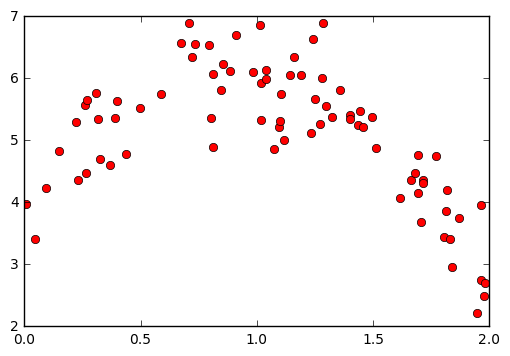

In [4]:
# Generate some data for the formula below
f = lambda x: 4 + 5 * x - 3 * x*x + 0.1 * x * x * x + np.random.normal(mu, sigma)
data = generate_data(f, 0, 2, n=80)
data_cv=generate_data(f, 0, 2, n=80)
plt.plot(pd.DataFrame(data)[0],pd.DataFrame(data)[1],"ro") # can you think of a cleaner way of ploting this? :) 

In [47]:
def rmse(yh,h):
    l=yh.size 
    return np.sqrt(np.sum((yh-h)*(yh-h))/l)

def score_rms(model,x,y):
    h=model.predict(x)
    return rmse(y,h)

def estimate_error_using_cv_RAW(data,model_n):
    domain = np.array([x[0] for x in data])
    Y = np.array([x[1] for x in data])
    X = monomials(domain, model_n) # since our model is w0+w1*x^n
    #kfold =cross_validation.KFold(n=len(data),n_folds=8,shuffle=True) # 8 way cross-validation, Can you guess why we are using KFold? 
    cv_errors=cross_validation.cross_val_score(linear_model.LinearRegression(), X, Y, scoring=score_rms, cv=20)
    return cv_errors
def estimate_error_using_cv(data,model_n):
    return np.mean(estimate_error_using_cv_RAW(data,model_n)) #because of the way mean_squared_error is defined in scikit-learn 

def max_error_using_cv(data,model_n):
    return np.percentile(estimate_error_using_cv_RAW(data,model_n),65) #because of the way mean_squared_error is defined in scikit-learn 
def min_error_using_cv(data,model_n):
    return np.percentile(estimate_error_using_cv_RAW(data,model_n),35) #because of the way mean_squared_error is defined in scikit-learn 


def plot_data_and_model(data,model_n):
    #first fit the model: 
    domain = np.array([x[0] for x in data])
    Y = np.array([x[1] for x in data])
    X = monomials(domain, model_n) # since our model is w0+w1*x^n
    fitted_model=linear_model.LinearRegression().fit(X,Y) #using all data 
#     print("for our model we have w=",fitted_model.coef_)
    plt.plot(pd.DataFrame(data)[0],fitted_model.predict(X),"b",pd.DataFrame(data)[0],pd.DataFrame(data)[1],"ro") # can you think of a cleaner way of ploting this? :) 

### Now let's experiment and make sure the #'s we are getting are ok: 

Things to medidate on:
    1. How can you *eyeball* the results from `estimate_error_using_cv` ?
    2. by walking thoughtthe models of different n's can you see which model is likely to be the best? 

0.98888645813693332

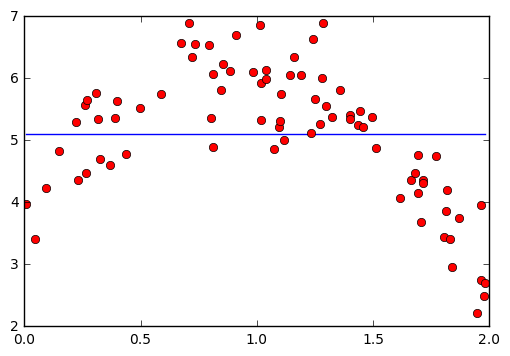

In [48]:
plot_data_and_model(data,model_n=0)
estimate_error_using_cv(data,model_n=0)

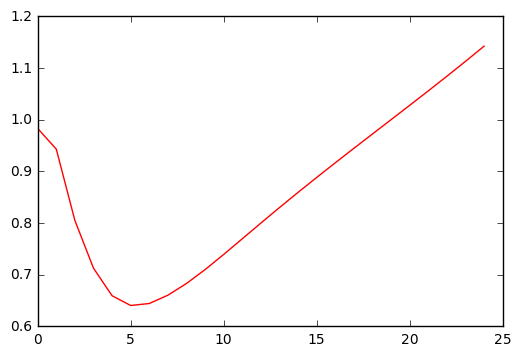

In [49]:
cv_res=pd.DataFrame([[deg, estimate_error_using_cv(data_cv,model_n=deg)] for deg in range(MAX_COMP) ])
plt.plot(cv_res[0],cv_res[1],"r") # the CV curve: 

# Lets Now Generate The non-CV curve 

Let's figure out how we are going to generate the other (blue curve) and see how well it works:

In [50]:
def estimate_error_using_train(data,model_n):
    domain = np.array([x[0] for x in data])
    Y = np.array([x[1] for x in data])
    X = monomials(domain, model_n) # since our model is w0+w1*x^n
    fitted_model=linear_model.LinearRegression().fit(X,Y) 
    err=rmse(Y,fitted_model.predict(X))
#     print("mse of error for this fit is: ",err)
    return err

estimate_error_using_train(data,model_n=1)

0.98091744968651506

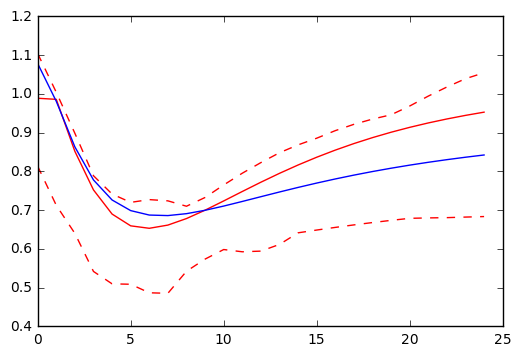

In [69]:
train_res=pd.DataFrame([[deg, estimate_error_using_train(data,model_n=deg)] for deg in range(MAX_COMP) ])
cv_res=pd.DataFrame([[deg, estimate_error_using_cv(data,model_n=deg)] for deg in range(MAX_COMP) ])
cv_max=pd.DataFrame([[deg, max_error_using_cv(data,model_n=deg)] for deg in range(MAX_COMP) ])
cv_min=pd.DataFrame([[deg, min_error_using_cv(data,model_n=deg)] for deg in range(MAX_COMP) ])
plt.plot(cv_res[0],cv_res[1],'r',train_res[0],train_res[1],'b',cv_min[0],cv_min[1],'r--',cv_max[0],cv_max[1],'r--') # the CV curve: 

# Notes About Results

In the curve above the bias and variance section can be seen on the left and the right. The bias component explains why the RMS error decreases from around 0 to around 5 and the Variance component of the error can be seen from around 7 to 25. 

## Why is this curve not exactly like the common bias-variance tradeoff curves?
The above curve does not look exactly like the common 